#### `logistic Regression (From Scratch)`

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [3]:
class MyLogisticRegression():
    def __init__(self,num_iters=1000,learning_rate=0.01):
        self.num_iters = num_iters
        self.learning_rate = learning_rate
        self.weights = None 
        self.b = None
        self.mean = None
        self.std = None
        self.report = {}
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def standardize(self,X_train):
        self.mean = np.mean(X_train,axis=0)
        self.std = np.std(X_train,axis=0)
        return (X_train - self.mean)/self.std
    def fit(self,X_train,y_train):
        starting_time = time.time()
        X_train = self.standardize(X_train) ; y_train = np.mat(y_train).T
        n,m = X_train.shape #455,30
        # self.weights = np.random.randn(m, 1) * 0.01 ; self.b = 0
        self.weights = np.ones((m,1)) # 30,1 
        self.b = 0
        for i in range(self.num_iters):
            # (455,30) (30,1) = (455,1)
            h = self.sigmoid(np.dot(X_train,self.weights)+self.b)# (n,1)= (n,m)*(m,1)
            # (30,455)*(455,1) = (30,1) 
            dw = (1/n)*np.dot(X_train.T,(h- y_train)) # (m,1) = (m,n) (n,1))
            db = (1/n)*np.sum(h-y_train)  
            # 
            self.weights = self.weights - self.learning_rate*dw
            self.b = self.b - self.learning_rate*db
        self.report['training_time'] = time.time() - starting_time
    def predict(self,X_test):
        starting_time = time.time()
        X_test = (X_test - self.mean) / self.std
        # (n,m)*(m,1) = (n,1)
        predictions = self.sigmoid(np.dot(X_test,self.weights) + self.b).A.ravel()# (114,30)@(m,1)
        self.report['testing_time'] = time.time() - starting_time
        return (predictions> 0.5).astype(int)
    def calc_report(self,y_test,y_pred):
        # Calc Accuracy
        num_of_coorect_preds = np.sum(y_test == y_pred)
        total_preds = len(y_test)
        self.report['accuracy'] = round(num_of_coorect_preds/total_preds,2)
        # 
        TP = np.sum((y_test== 1) & (y_pred==1))
        FP = np.sum((y_test==0) & (y_pred==1)) 
        TN = np.sum((y_test == 0) & (y_pred == 0))  
        FN = np.sum((y_test==1)&(y_pred==0))
        # Calc Precision
        self.report['precision'] = round(TP/(TP+FP),2)
        # Calc Recall
        self.report['recall'] = round(TP/(TP+FN),2)
         # Calculate F1 Score
        if (self.report['precision'] + self.report['recall']) > 0:
            self.report['f1_score'] = round(2 * (self.report['precision'] * self.report['recall']) / (self.report['precision'] + self.report['recall']), 2)
        else: 
            self.report['f1_score'] = 0
        # Calculate MCC
        mcc_numerator = (TP * TN) - (FP * FN)
        mcc_denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        self.report['mcc'] = round(mcc_numerator / mcc_denominator, 2) if mcc_denominator != 0 else 0
        return self.report

In [4]:
files_paths = {
  "with_fs" : ('../../../data/processed/train_filtered.csv','../../../data/processed/test_filtered.csv'),
  "without_fs" : ('../../../data/processed/train_data.csv','../../../data/processed/test_data.csv')
}

metrics_with_fs = None
metrics_without_fs = None


`Calculate The report classification of the two cases (with features selection and without features selection)`

In [5]:
for files_type in files_paths:
  # Getting files
  training_file = files_paths[files_type][0] 
  testing_file = files_paths[files_type][1] 
  training_data = pd.read_csv(training_file)
  testing_data = pd.read_csv(testing_file)
  # 
  X_train = training_data.drop(columns=["target"])
  y_train = training_data["target"]
  # 
  X_test = testing_data.drop(columns=["target"])
  y_test = testing_data["target"]
  # 
  # 
  lr_model = MyLogisticRegression(num_iters=10000,learning_rate=0.1)
  lr_model.fit(X_train,y_train)
  y_pred = lr_model.predict(X_test)
  # 
  if files_type == 'with_fs' : metrics_with_fs =  lr_model.calc_report(y_test,y_pred) 
  elif files_type == 'without_fs' : metrics_without_fs =  lr_model.calc_report(y_test,y_pred)

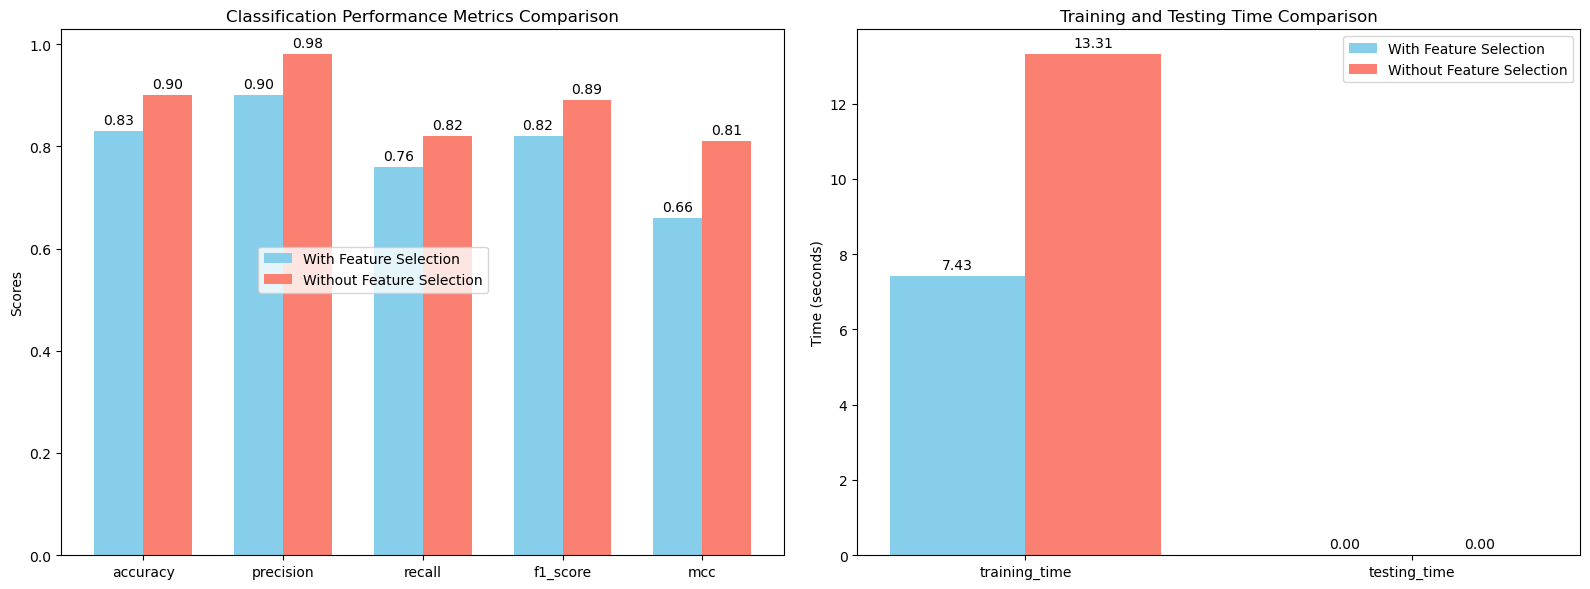

In [6]:
# Define metrics to plot
performance_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'mcc']
time_metrics = ['training_time', 'testing_time']

# Extract values
with_fs_performance = [metrics_with_fs[m] for m in performance_metrics]
without_fs_performance = [metrics_without_fs[m] for m in performance_metrics]

with_fs_time = [metrics_with_fs[m] for m in time_metrics]
without_fs_time = [metrics_without_fs[m] for m in time_metrics]

# Set up the bar chart parameters
x_perf = np.arange(len(performance_metrics))  # the label locations
x_time = np.arange(len(time_metrics))
width = 0.35  # the width of the bars

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed

# ============================
# Plot Performance Metrics
# ============================
rects1 = ax1.bar(x_perf - width/2, with_fs_performance, width, label='With Feature Selection', color='skyblue')
rects2 = ax1.bar(x_perf + width/2, without_fs_performance, width, label='Without Feature Selection', color='salmon')

# Add labels, title, and custom x-axis tick labels
ax1.set_ylabel('Scores')
ax1.set_title('Classification Performance Metrics Comparison')
ax1.set_xticks(x_perf)
ax1.set_xticklabels(performance_metrics)
ax1.legend(bbox_to_anchor=(0.6, 0.6))

# Function to attach a text label above each bar in rects
def autolabel(ax, rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax1, rects1)
autolabel(ax1, rects2)

# ============================
# Plot Time Metrics
# ============================
rects3 = ax2.bar(x_time - width/2, with_fs_time, width, label='With Feature Selection', color='skyblue')
rects4 = ax2.bar(x_time + width/2, without_fs_time, width, label='Without Feature Selection', color='salmon')

# Add labels, title, and custom x-axis tick labels
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training and Testing Time Comparison')
ax2.set_xticks(x_time)
ax2.set_xticklabels(time_metrics)
ax2.legend()

autolabel(ax2, rects3)
autolabel(ax2, rects4)

# Adjust layout for better spacing
fig.tight_layout()

# Display the plot
plt.show()
